## Iron Mike UFC Fight Program
Our goal here is to develop a machine learning program that uses previous UFC fight statistics to determine who is most likely to win a fight. Our code is organized into the following sections:
1. Preprocessing
2. Initial Data Visualization
3. Data Cleaning
4. Feature Engineering
5. More Data Cleaning
7. Model Training and Analysis

## Preprocessing
- Importing necessary packages
- Loading the dataset and assigning the features (X) and label (y)

In [48]:
# -------- PREPROCESSING -------- #
# Importing necessary packages

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
import tabulate
import pickle

In [27]:
# -------- PREPROCESSING -------- #
# Loading the dataset and assigning the features (X) and label (y)

# Load the cleaned UFC dataset
# Only some initial cleaning things were done here, more cleaning to come in feature engineering
df = pd.read_csv("cleaned ufc master dataset.csv")
# print(df.head)

# Make the prediction label 'Winner' numeric where 1 = Red Wins and 0 = Blue Wins
# Assign the y as this column
df['Winner'] = [1 if win == 'Red' else 0 for win in df['Winner']]
y = df['Winner']

## Initial Data Visualization
- Understanding feature correlation with prediction label
- Visualizing key feature columns

In [28]:
# -------- INITIAL DATA VISUALIZATION -------- #
# Understanding feature correlation with prediction label

# Find the categorical and numerical columns
categorical_cols = [col for col in df.columns if df[col].dtypes == 'object']
numerical_cols = [col for col in df.columns if col not in categorical_cols]

# Go through the numerical columns and find their correlation with the prediction label
corr_cols = [col for col in df.columns if df[col].dtype == 'int64' or df[col].dtype == 'float64']
corr_dict = {}
for col in corr_cols:
    corr_dict[col] = abs(df[col].corr(df['Winner']))

# Find the columns with a correlation higher than or equal to 0.17
high_corr = {}
for w in sorted(corr_dict, key=corr_dict.get):
    if corr_dict[w] >= 0.17:
        high_corr[w] = corr_dict[w]
    print(w, corr_dict[w])
print(high_corr.keys())

TotalTitleBoutDif 0.00011429824793766647
EmptyArena 0.0004297931279022553
LoseStreakDif 0.0006436109376376177
BlueWinsBySubmission 0.0037874067699475295
SubDif 0.003860637630332731
BlueWins 0.004191325667423433
RedWeightLbs 0.0047418571466945735
RedWinsBySubmission 0.007435326302783935
LossDif 0.007744925143067027
BlueWeightLbs 0.007975539850874536
BlueWinsByKO 0.008489101705553191
RedWinsByDecisionUnanimous 0.01008767110360114
RedHeightCms 0.010397073354768548
BlueWinsByDecisionUnanimous 0.0104172950091766
RedLongestWinStreak 0.015020527673281981
RedTotalTitleBouts 0.015320090277063086
FinishRound 0.016287405732814286
RFeatherweightRank 0.016710881466059778
TotalFightTimeSecs 0.01692903409458633
BlueHeightCms 0.017229689050827435
NumberOfRounds 0.017778173972654812
BlueTotalRoundsFought 0.02132395049203586
BlueTotalTitleBouts 0.022004316406273004
RedReachCms 0.022147687167118398
BlueReachCms 0.0227681860345945
BlueLongestWinStreak 0.02337040355726067
RedAvgSigStrLanded 0.0269374077314

/Users/kyliehoar/anaconda3/envs/mongoDb/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/kyliehoar/anaconda3/envs/mongoDb/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/kyliehoar/anaconda3/envs/mongoDb/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/kyliehoar/anaconda3/envs/mongoDb/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/kyliehoar/anaconda3/envs/mongoDb/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


<Axes: xlabel='BKOOdds', ylabel='RKOOdds'>

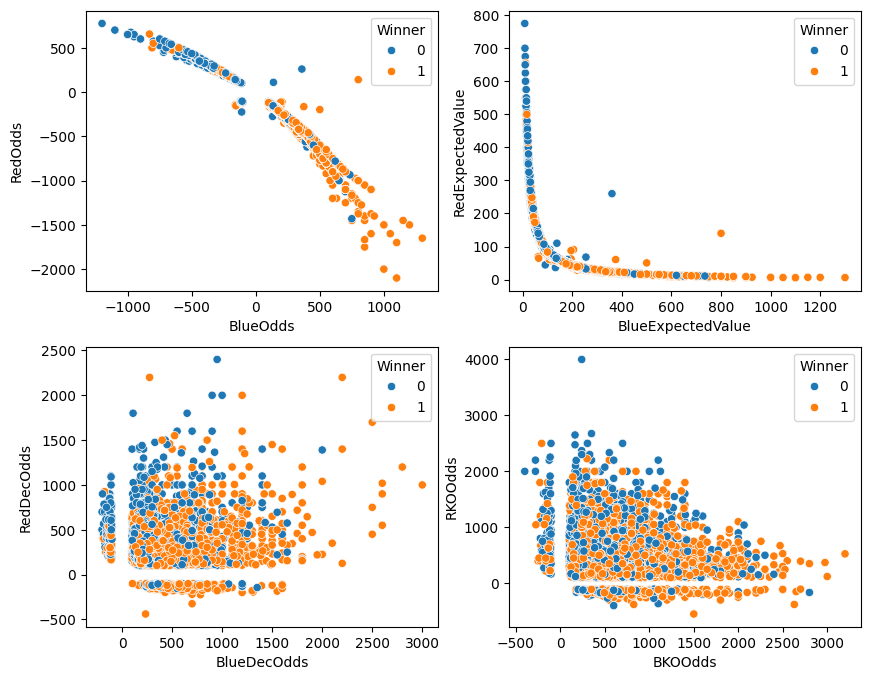

In [29]:
# -------- INITIAL DATA VISUALIZATION -------- #
# Visualizing key feature columns

# Create an matplot lib subplot that looks at how winners are distributed across key columns with high correlation
# Specifically looking at the Odds, Exepcted Value, Dec Odds, and KO Odds columns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.scatterplot(x="BlueOdds", y="RedOdds", hue="Winner", data=df, ax=axs[0, 0])
sns.scatterplot(x="BlueExpectedValue", y="RedExpectedValue", hue="Winner", data=df, ax=axs[0, 1])
sns.scatterplot(x="BlueDecOdds", y="RedDecOdds", hue="Winner", data=df, ax=axs[1, 0])
sns.scatterplot(x="BKOOdds", y="RKOOdds", hue="Winner", data=df, ax=axs[1, 1])

### Initial Data Visualization Conclusions

We created these 4 scatterplots to further analyze the relationship that some standout features had with the Winner (label) column. Based on the scatterplots shown above, we draw the following conclusions:
- The top left plot shows that when Blue's odds are higher, the chance that Red wins also increases (and vice versa). This indicates that the odds features are measuring the odds that the given fighter will lose and not win.
- The top right plot shows that as Blue's expected value increases, the chance that Blue wins also increases (and vice versa). Contrary to the other plot, this aligns with logic that the higher the expected value for Blue, the higher the chance that Blue wins.
- The bottom left plot shows how the measures of Blue and Red odds to win the fight by decision relate to the Winner label. From this scatterplot, it is clear that there are no measures for either at 0, which means the odds for decision are likely all non-zero values. Furthermore, if the odds for decision are low or negative for the Red fighter, the chances for winning seem to generally higher for the Red opponent and vice versa.
- The bottom right plot shows how the measures of Blue and Red odds to win the fight by knockout relate to the Winner label. From this scatterplot, it is clear that there are no measures again for either opponent at 0, which means that the odds for win by knockout are likely all non-zero values. Furthermore, if the odds for decision are low or negative for a fighter's opponent, the chances of the fighter winning are not as definitive as the previous plot. There seems to be a larger blend in results between Red and Blue fighters across all values in the plot.

## Data Cleaning
- Removing insignificant columns
- Identifying and fixing data inconsistencies
- Numericalization of features

In [30]:
# -------- DATA CLEANING -------- #
# Removing insignificant columns

# Look at the columns between 'EmptyArena' and 'BetterRank' to look at the number of null values
print(df.loc[:,'EmptyArena':'BetterRank'].isnull().sum())

# Remove Weight Class Rank columns because they have a majority null values (therefore insignificant to our model)
df.drop(df.loc[:,'BMatchWCRank':'BPFPRank'], axis=1, inplace = True)

EmptyArena               1239
BMatchWCRank             5123
RMatchWCRank             4558
RWFlyweightRank          6183
RWFeatherweightRank      6266
RWStrawweightRank        6135
RWBantamweightRank       6128
RHeavyweightRank         6096
RLightHeavyweightRank    6097
RMiddleweightRank        6096
RWelterweightRank        6091
RLightweightRank         6098
RFeatherweightRank       6103
RBantamweightRank        6098
RFlyweightRank           6095
RPFPRank                 6038
BWFlyweightRank          6205
BWFeatherweightRank      6274
BWStrawweightRank        6180
BWBantamweightRank       6175
BHeavyweightRank         6133
BLightHeavyweightRank    6158
BMiddleweightRank        6141
BWelterweightRank        6160
BLightweightRank         6162
BFeatherweightRank       6155
BBantamweightRank        6157
BFlyweightRank           6151
BPFPRank                 6211
BetterRank                  0
dtype: int64


In [31]:
# -------- DATA CLEANING -------- #
# Identifying and fixing data inconsistencies

# There is a spelling mistake in the BlueStance column so we fix it here
df['BlueStance'] = df['BlueStance'].replace({
    'Switch ': 'Switch',
    None : 'Unknown'
})
print(df['BlueStance'].unique())

# There is also a spelling mistake in the RedFighter column so we fix it here
df['RedFighter'] = df['RedFighter'].replace({
    ' Jun Yong Park': 'Jun Yong Park'
})
print(df['RedFighter'].unique())

['Switch' 'Southpaw' 'Orthodox' 'Unknown' 'Open Stance']
['Neil Magny' 'Gerald Meerschaert' 'Gaston Bolanos' ... 'Caol Uno'
 'Eliot Marshall' 'Eric Schafer']


In [32]:
# -------- DATA CLEANING -------- #
# Numericalization of features

# Taking the Title Bout column and assigning each string value to a numerical value for model training
# 1 = True and 0 = False
df['TitleBout'] = [1 if tb == True else 0 for tb in df['TitleBout']]

# Taking the Better Rank column and assigning each string value to a numerical value for model training and to eliminate potential number bias with ranking
# -1 = Red and 1 = Blue, 0 otherwise
df['BetterRank'] = [-1 if br == 'Red'
                    else 1 if br == 'Blue'
                    else 0 for br in df['BetterRank']]

# Taking the Blue/Red Stance columns and assigning each stance type to a numerical value for model training
# See outputted dictionaries for stance <-> number assignments
le1 = LabelEncoder()
df['BlueStance'] = le1.fit_transform(df['BlueStance'])
print("Blue Stances")
print({label: int(num) for label, num in zip(le1.classes_, le1.transform(le1.classes_))})
print("\n")

le2 = LabelEncoder()
df['RedStance'] = le2.fit_transform(df['RedStance'])
print("Red Stances")
print({label: int(num) for label, num in zip(le2.classes_, le2.transform(le2.classes_))})
print("\n")

# Taking the Blue/Red Fighter columns and assigning each fighter name to a numerical value for model training
# See outputted dictionary for fighter name <-> number assignments
fighters = ['BlueFighter', 'RedFighter']
le3 = LabelEncoder()
for i in df[fighters]:
    df[i] = le3.fit_transform(df[i])
print("Fighters")
print({label: int(num) for label, num in zip(le3.classes_, le3.transform(le3.classes_))})

Blue Stances
{'Open Stance': 0, 'Orthodox': 1, 'Southpaw': 2, 'Switch': 3, 'Unknown': 4}


Red Stances
{'Open Stance': 0, 'Orthodox': 1, 'Southpaw': 2, 'Switch': 3}


Fighters
{'AJ Dobson': 0, 'AJ Fletcher': 1, 'Aalon Cruz': 2, 'Aaron Phillips': 3, 'Aaron Riley': 4, 'Aaron Rosa': 5, 'Aaron Simpson': 6, 'Abdul Razak Alhassan': 7, 'Abdul-Kareem Al-Selwady': 8, 'Abel Trujillo': 9, 'Abu Azaitar': 10, 'Abubakar Nurmagomedov': 11, 'Abus Magomedov': 12, 'Adam Milstead': 13, 'Adam Wieczorek': 14, 'Adam Yandiev': 15, 'Adrian Yanez': 16, 'Adriano Martins': 17, 'Aiemann Zahabi': 18, 'Ailin Perez': 19, 'Aisling Daly': 20, 'Akbarh Arreola': 21, 'Akira Corassani': 22, 'Al Iaquinta': 23, 'Alan Baudot': 24, 'Alan Belcher': 25, 'Alan Jouban': 26, 'Alan Omer': 27, 'Alan Patrick': 28, 'Alatengheili': 29, 'Albert Cheng': 30, 'Albert Duraev': 31, 'Albert Morales': 32, 'Albert Tumenov': 33, 'Alberto Mina': 34, 'Alberto Uda': 35, 'Alejandro Perez': 36, 'Alekander Volkov': 37, 'Aleksa Camur': 38, 'Aleksei Kun

## Feature Engineering
- Recalculating features

In [33]:
# -------- FEATURE ENGINEERING -------- #
# Recalculating features

# Find the columns that represent differences of Red and Blue values
df_filtered = df.filter(regex='Dif$', axis=1)
print(df_filtered.columns)

Index(['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif',
       'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif',
       'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif',
       'AvgTDDif'],
      dtype='object')


### Some Feature Engineering Conclusions

Each Difference column is the difference between Blue and Red outcomes for that feature of the data. The current filtered columns are:
1. LoseStreakDif: BlueCurrentLoseStreak - RedCurrentLostStreak
2. WinStreakDif: BlueCurrentWinStreak - RedCurrentWinStreak
3. LongestWinStreakDif: BlueLongestWinStreak - RedLongestWinStreak
4. WinDif: BlueWins - RedWins
5. LossDif: BlueLosses - RedLosses
6. TotalRoundDif: BlueTotalRoundsFought - RedTotalRoundsFought
7. TotalTitleBoutDif: BlueTotalTitleBouts - RedTotalTitleBouts
8. KODif: BlueWinsByKO - RedWinsByKO
9. SubDif: BlueWinsBySubmission - RedWinsBySubmission
10. HeightDif: BlueHeightCms - RedHeightCms
11. ReachDif: BlueReachCms - RedReachCms
12. AgeDif: BlueAge - RedAge
13. SigStrDif: BlueAvgSigStrLanded - RedAvgSigStrLanded
14. AvgSubAttDif: BlueAvgSubAtt - RedAvgSubAtt
15. AvgTDDif: BlueAvgTDLanded - RedAvgTDLanded

In order for us to create our model, we thought it would be best to find the differences for the rest of the Red/Blue columns. This way the model is trained on the difference between Red and Blue values, and not individual stats.

In [34]:
# -------- FEATURE ENGINEERING -------- #
# Recalculating features

# Calculate the difference columns from the rest of the Red/Blue features and assign them to new columns in the dataset
df['OddsDif'] = df["BlueOdds"] - df["RedOdds"]
df['EVDif'] = df['BlueExpectedValue'] - df['RedExpectedValue']
df['SigStrPctDif'] = df['BlueAvgSigStrPct'] - df['RedAvgSigStrPct']
df['AvgTDPctDif'] = df['BlueAvgTDPct'] - df['RedAvgTDPct']
df['WinsDecByUnanDif'] = df['BlueWinsByDecisionUnanimous'] - df['RedWinsByDecisionUnanimous']
df['DecOddsDif'] = df['BlueDecOdds'] - df['RedDecOdds']
df['SubOddsDif'] = df['BSubOdds'] - df['RSubOdds']
df['KOOddsDif'] = df['BKOOdds'] - df['RKOOdds']
df['StanceDif'] = df['BlueStance'] - df['RedStance']

In [35]:
# -------- FEATURE ENGINEERING -------- #
# Recalculating features

# Drop all of the original Red/Blue features because they are no longer needed for analysis
drop_cols = [
    'BlueCurrentLoseStreak',
    'RedCurrentLoseStreak',
    'BlueCurrentWinStreak',
    'RedCurrentWinStreak',
    'BlueLongestWinStreak',
    'RedLongestWinStreak',
    'BlueWins',
    'RedWins',
    'BlueLosses',
    'RedLosses',
    'BlueTotalRoundsFought',
    'RedTotalRoundsFought',
    'BlueTotalTitleBouts',
    'RedTotalTitleBouts',
    'BlueWinsByKO',
    'RedWinsByKO',
    'BlueWinsBySubmission',
    'RedWinsBySubmission',
    'BlueHeightCms',
    'RedHeightCms',
    'BlueReachCms',
    'RedReachCms',
    'BlueAge',
    'RedAge',
    'BlueAvgSigStrLanded',
    'RedAvgSigStrLanded',
    'BlueAvgSubAtt',
    'RedAvgSubAtt',
    'BlueAvgTDLanded',
    'RedAvgTDLanded',
    'BlueOdds',
    'RedOdds',
    'BlueExpectedValue',
    'RedExpectedValue',
    'BlueAvgSigStrPct',
    'RedAvgSigStrPct',
    'BlueAvgTDPct',
    'RedAvgTDPct',
    'BlueWinsByDecisionUnanimous',
    'RedWinsByDecisionUnanimous',
    'BlueDecOdds',
    'RedDecOdds',
    'BSubOdds',
    'RSubOdds',
    'BKOOdds',
    'RKOOdds',
    'BlueStance',
    'RedStance',
    # Drop the columns below because they are the same for each fighter, therefore they do not help with prediction
    'BlueWeightLbs',
    'RedWeightLbs',
    'WeightClass',
    'Gender',
    'NumberOfRounds',
    'EmptyArena',
    'Finish',
    'FinishDetails',
    'FinishRound',
    'FinishRoundTime',
    'TotalFightTimeSecs'
]
df.drop(drop_cols, axis=1, inplace=True)

## More Data Cleaning
- Impute missing values

In [36]:
# -------- DATA CLEANING -------- #
# Impute missing values

# Assign X to the columns of the modified and improved dataset, minus the prediction label column
X = df.drop('Winner', axis=1)

# Initialize a KNN Imputer to handle missing values in the dataset
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Fit and transform the data using the KNN Imputer
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

## Imputation Rationale
The reason why our group decided to use `KNNImputer` to handle missing values is because `KNNImputer` is good at detecting local patterns and similarities in the data. We also looked at using scikit's `SimpleImputer` and the `IterativeImputer`, but we ultimately determined that `KNNImputer` would be the best option for our dataset. We decided not to use the `SimpleImputer` because it does not pick up on any key relationships between features. We decided not to use the `IterativeImputer` because it works best for features with strong interdependencies, which is something that our dataset lacks (see the correlation analyses in data visualization).

## Model Training and Analysis
- Building training and test datasets
- Model 1: Random Forest Classification
- Model 2: Decision Tree Classification
- Model 3: K-Nearest Neighbors (KNN) Classification
- Model 4: Support Vector Machine (SVM) Classification
- Output accuracy results
- Save best-performing model for UI

In [37]:
# -------- MODEL TRAINING AND ANALYSIS -------- #
# Building training and test datasets

# Split all of the data into training and test data (80:20 ratio)
# Use all possible features for X
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Identify the columns that will be used in the UI to predict the winner of a new fight matchup
top_cols = ['AgeDif', 'HeightDif', 'ReachDif', 'WinDif', 'LossDif', 'WinStreakDif', 'LoseStreakDif', 'LongestWinStreakDif']
X_top = X_imputed[top_cols]

# Split this new data into training and test data (80:20 ratio)
# Use only the columns that will be used in our UI to predict the winner of a new fight matchup
X_top_train, X_top_test, y_top_train, y_top_test = train_test_split(X_top, y, test_size=0.2, random_state=43)

In [38]:
# -------- MODEL TRAINING AND ANALYSIS -------- #
# Model 1: Random Forest Classification
# Training and testing using the whole set of features

# Define parameter grid for optimization
param_grid = {'n_estimators': [10, 50, 100, 150, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]}

# Initialize a Random Forest Classifier object
rf = RandomForestClassifier(random_state=41)

# Perform a Grid Search on the potential parameters and fit these to the training data
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Return the best parameters and accuracy of the model with the best parameter
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the optimal model on the test set and return the accuracy score
best_rf_all = grid_search.best_estimator_
y_pred = best_rf_all.predict(X_test)
rf_all_accuracy = accuracy_score(y_test, y_pred)
rf_all_dif = grid_search.best_score_ - rf_all_accuracy
print(f"Test Set Accuracy: {rf_all_accuracy:.4f}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'n_estimators': 240}
Best Cross-Validation Accuracy: 0.6539840637450199
Test Set Accuracy: 0.6629


In [39]:
# -------- MODEL TRAINING AND ANALYSIS -------- #
# Model 1: Random Forest Classification
# Training and testing using the UI features

# Define parameter grid for optimization
param_grid = {'n_estimators': [10, 50, 100, 150, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]}

# Initialize a Random Forest Classifier object
rf = RandomForestClassifier(random_state=41)

# Perform a Grid Search on the potential parameters and fit these to the training data
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_top_train, y_top_train)

# Return the best parameters and accuracy of the model with the best parameter
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the optimal model on the test set and return the accuracy score
best_rf_ui = grid_search.best_estimator_
y_pred = best_rf_ui.predict(X_top_test)
rf_top_accuracy = accuracy_score(y_top_test, y_pred)
rf_top_dif = grid_search.best_score_ - rf_top_accuracy
print(f"Test Set Accuracy: {rf_top_accuracy:.4f}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'n_estimators': 300}
Best Cross-Validation Accuracy: 0.5603585657370518
Test Set Accuracy: 0.5610


In [40]:
# -------- MODEL TRAINING AND ANALYSIS -------- #
# Model 2: Decision Tree Classification
# Training and testing using the whole set of features

# Define parameter grid for optimization
param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'criterion': ['gini']}

# Initialize a Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=42)

# Perform a Grid Search on the potential parameters and fit these to the training data
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Return the best parameters and accuracy of the model with the best parameter
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the optimal model on the test set and return the accuracy score
best_dt_all = grid_search.best_estimator_
y_pred = best_dt_all.predict(X_test)
dt_all_accuracy = accuracy_score(y_test, y_pred)
dt_all_dif = grid_search.best_score_ - dt_all_accuracy
print(f"Test Set Accuracy: {dt_all_accuracy:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 3}
Best Cross-Validation Accuracy: 0.6490039840637449
Test Set Accuracy: 0.6534


In [41]:
# -------- MODEL TRAINING AND ANALYSIS -------- #
# Model 2: Decision Tree Classification
# Training and testing using the UI features

# Define parameter grid for optimization
param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'criterion': ['gini']}

# Initialize a Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=42)

# Perform a Grid Search on the potential parameters and fit these to the training data
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_top_train, y_top_train)

# Return the best parameters and accuracy of the model with the best parameter
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the optimal model on the test set and return the accuracy score
best_dt_ui = grid_search.best_estimator_
y_pred = best_dt_ui.predict(X_top_test)
dt_top_accuracy = accuracy_score(y_top_test, y_pred)
dt_top_dif = grid_search.best_score_ - dt_top_accuracy
print(f"Test Set Accuracy: {dt_top_accuracy:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 2}
Best Cross-Validation Accuracy: 0.5886454183266931
Test Set Accuracy: 0.5865


In [42]:
# -------- MODEL TRAINING AND ANALYSIS -------- #
# Model 3: K-Nearest Neighbors (KNN) Classification
# Training and testing using the whole set of features

# Define parameter grid for optimization
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Initialize a K-Nearest Neighbor Classifier object
knn = KNeighborsClassifier()

# Perform a Grid Search on the potential parameters and fit these to the training data
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Return the best parameters and accuracy of the model with the best parameter
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the optimal model on the test set and return the accuracy score
best_knn_all = grid_search.best_estimator_
y_pred = best_knn_all.predict(X_test)
knn_all_accuracy = accuracy_score(y_test, y_pred)
knn_all_dif = grid_search.best_score_ - knn_all_accuracy
print(f"Test Set Accuracy: {knn_all_accuracy:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_neighbors': 9}
Best Cross-Validation Accuracy: 0.6320717131474103
Test Set Accuracy: 0.6120


In [43]:
# -------- MODEL TRAINING AND ANALYSIS -------- #
# Model 3: K-Nearest Neighbors (KNN) Classification
# Training and testing using the UI features

# Define parameter grid for optimization
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Initialize a K-Nearest Neighbor Classifier object
knn = KNeighborsClassifier()

# Perform a Grid Search on the potential parameters and fit these to the training data
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_top_train, y_top_train)

# Return the best parameters and accuracy of the model with the best parameter
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the optimal model on the test set and return the accuracy score
best_knn_ui = grid_search.best_estimator_
y_pred = best_knn_ui.predict(X_top_test)
knn_top_accuracy = accuracy_score(y_top_test, y_pred)
knn_top_dif = grid_search.best_score_ - knn_top_accuracy
print(f"Test Set Accuracy: {knn_top_accuracy:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_neighbors': 9}
Best Cross-Validation Accuracy: 0.5406374501992032
Test Set Accuracy: 0.5578


In [44]:
# -------- MODEL TRAINING AND ANALYSIS -------- #
# Model 4: Support Vector Machine (SVM) Classification
# Training and testing using the whole set of features

# Define parameter grid for optimization
param_grid = {
    'C': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
    'kernel': ['poly', 'rbf'],
    'gamma': ['scale'],
}

# Initialize a Support Vector Machine Classifier object
svc = SVC(random_state=44)

# Perform a Grid Search on the potential parameters and fit these to the training data
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Return the best parameters and accuracy of the model with the best parameter
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Validation Accuracy: {grid_search.best_score_:.4f}")

# Evaluate the optimal model on the test set and return the accuracy score
best_svc_all = grid_search.best_estimator_
y_pred = best_svc_all.predict(X_test)
svc_all_accuracy = accuracy_score(y_test, y_pred)
svc_all_dif = grid_search.best_score_ - svc_all_accuracy
print(f"Test Accuracy: {svc_all_accuracy:.4f}")

Best Parameters: {'C': 0.6, 'gamma': 'scale', 'kernel': 'rbf'}
Best Validation Accuracy: 0.6588
Test Accuracy: 0.6574


In [45]:
# -------- MODEL TRAINING AND ANALYSIS -------- #
# Model 4: Support Vector Machine (SVM) Classification
# Training and testing using the UI features

# Define parameter grid for optimization
param_grid = {
    'C': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
    'kernel': ['poly', 'rbf'],
    'gamma': ['scale'],
}

# Initialize a Support Vector Machine Classifier object
svc = SVC(random_state=44)

# Perform a Grid Search on the potential parameters and fit these to the training data
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3)
grid_search.fit(X_top_train, y_top_train)

# Return the best parameters and accuracy of the model with the best parameter
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Validation Accuracy: {grid_search.best_score_:.4f}")

# Evaluate the optimal model on the test set and return the accuracy score
best_svc_ui = grid_search.best_estimator_
y_pred = best_svc_ui.predict(X_top_test)
svc_top_accuracy = accuracy_score(y_top_test, y_pred)
svc_top_dif = grid_search.best_score_ - svc_top_accuracy
print(f"Test Accuracy: {knn_top_accuracy:.4f}")

Best Parameters: {'C': 0.55, 'gamma': 'scale', 'kernel': 'rbf'}
Best Validation Accuracy: 0.5896
Test Accuracy: 0.5578


In [ ]:
# -------- MODEL TRAINING AND ANALYSIS -------- #
# Output accuracy results

# Pair model names and descriptions with the variable for its accuracy
accuracies = [
    ['Random Forest - All Features', rf_all_accuracy, rf_all_dif],
    ['Random Forest - UI Features', rf_top_accuracy, rf_top_dif],
    ['Decision Tree - All Features', dt_all_accuracy, dt_all_dif],
    ['Decision Tree - UI Features', dt_top_accuracy, dt_top_dif],
    ['KNN - All Features', knn_all_accuracy, knn_all_dif],
    ['KNN - UI Features', knn_top_accuracy, knn_top_dif],
    ['SVM - All Features', svc_all_accuracy, svc_all_dif],
    ['SVM - UI Features', svc_top_accuracy, svc_top_dif]
]

# Identify the necessary headers for the results table
headers = ["Model", "Accuracy", "Training - Test Accuracy"]

# Output a results table showing each model we created and its associated accuracy score
print(tabulate.tabulate(accuracies, headers, tablefmt="fancy_grid"))

╒══════════════════════════════╤════════════╤════════════════════════════╕
│ Model                        │   Accuracy │   Training - Test Accuracy │
╞══════════════════════════════╪════════════╪════════════════════════════╡
│ Random Forest - All Features │   0.662948 │                -0.00896414 │
├──────────────────────────────┼────────────┼────────────────────────────┤
│ Random Forest - UI Features  │   0.560956 │                -0.00059761 │
├──────────────────────────────┼────────────┼────────────────────────────┤
│ Decision Tree - All Features │   0.653386 │                -0.00438247 │
├──────────────────────────────┼────────────┼────────────────────────────┤
│ Decision Tree - UI Features  │   0.586454 │                 0.00219124 │
├──────────────────────────────┼────────────┼────────────────────────────┤
│ KNN - All Features           │   0.611952 │                 0.0201195  │
├──────────────────────────────┼────────────┼────────────────────────────┤
│ KNN - UI Features      

In [49]:
# -------- MODEL TRAINING AND ANALYSIS -------- #
# Save best-performing model for UI

# Assign the UI model as the best-performing UI model
# We decided that the best-performing model should be the one with the highest accuracy score and low training - test accuracy difference
ui_model = best_svc_ui

# Save the best-performing model to a pkl file for the UI
with open('ufc_ui_model.pkl', 'wb') as f:
    pickle.dump(ui_model, f)
print("Model saved as ufc_model.pkl")

Model saved as ufc_model.pkl
